### Comparision between LLM & RAG outputs using LangGraph

In [37]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langgraph.graph import Graph, StateGraph, START, END
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv 
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate

load_dotenv()

loader = DirectoryLoader('./', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=40,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [15]:
# ! pip install sentence-transformers
# ! pip install langchain_huggingface
# ! pip install chromadb

In [ ]:
model_name = "BAAI/bge-small-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

In [17]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [29]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [19]:
query = "Tell me about llama3?"
docs = retriever.get_relevant_documents(query)
print(docs)

/var/folders/jm/nxthdk892t3b94442_lcxbfm0000gn/T/ipykernel_22556/2266497744.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


[Document(metadata={'source': 'llama3.txt'}, page_content='* We’re dedicated to developing Llama 3 in a responsible way, and we’re offering various resources to help others use it responsibly as well. This includes introducing new trust and safety tools with Llama Guard 2, Code Shield, and CyberSec Eval 2.'), Document(metadata={'source': 'llama3.txt'}, page_content='With Llama 3, we set out to build the best open models that are on par with the best proprietary models available today. We wanted to address developer feedback to increase the overall helpfulness of Llama 3 and are doing so while continuing to play a leading role on responsible use and deployment of LLMs. We are embracing the open source ethos of releasing early and often to enable the community'), Document(metadata={'source': 'llama3.txt'}, page_content='Our goals for Llama 3'), Document(metadata={'source': 'llama3.txt'}, page_content='* In the coming months, we expect to introduce new capabilities, longer context windows

In [ ]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [ ]:
AgentState

In [21]:
llm= ChatOpenAI()

In [22]:
def function_1(state):
    messages = state['messages']
    question = messages[-1]   
    
    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + question
    response = llm.invoke(complete_query)
    state['messages'].append(response.content) 
    return state

def function_2(state):
    messages = state['messages']
    question = messages[0] 

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [31]:
graph = Graph()

graph.add_node("Agent", function_1)
graph.add_node("RAGtool", function_2)
graph.add_edge(START, 'Agent')
graph.add_edge('Agent', 'RAGtool')
graph.add_edge('RAGtool', END)


graph = graph.compile()

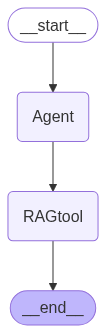

In [32]:
try:
    display(Image(graph.get_graph().draw_mermaid_png(max_retries=2, retry_delay=2.0)))
except Exception as e:
    print(e)

In [33]:
inputs = {"messages": ["Tell me about llama3 model"]}
graph.invoke(inputs)

'The Llama 3 model aims to be one of the best open models available, comparable to the best proprietary models currently on the market. The developers are actively seeking feedback to improve the overall usefulness of the model. They are also focused on responsible use and deployment of LLMs, while embracing the open source ethos of releasing updates frequently to benefit the community. In the near future, new capabilities, longer context windows, additional model sizes, enhanced performance, and a research paper on Llama 3 are expected to be introduced.'

In [34]:
inputs = {"messages": ["tell me 3 property of llama3?"]}
graph.invoke(inputs)

"1. Llama 3 is being developed in a responsible way.\n2. Various resources are being offered to help others use Llama 3 responsibly, including new trust and safety tools such as Llama Guard 2, Code Shield, and CyberSec Eval 2.\n3. The document discussing Llama 3's goals mentions the dedication to responsible development and the provision of resources for responsible use twice."

In [35]:
for output in graph.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'Agent':
---
{'messages': ['tell me 3 property of llama3?', 'Japan', 'Japan']}

---

Output from node 'RAGtool':
---
1. Llama 3 is being developed in a responsible way.
2. Llama 3 offers various trust and safety tools such as Llama Guard 2, Code Shield, and CyberSec Eval 2.
3. Llama 3 is intended to help others use it responsibly.

---



In [38]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [39]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
 

In [40]:
def function_1(state):
    print('-> Calling Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    
    templete = """ Your task is to provide only the topic based on the user query. 
        Only output the topic among: [Japan , Sports , Not Related]. Don't include reasoning. Following is the user query:  {question}
        {format_instructions} """
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'Japan' in last_message or 'Sports' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [41]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("agent", function_1)
graph.add_node("RAG", function_2)
graph.add_node("LLM", function_3)

graph.set_entry_point("agent")

In [42]:
# conditional edges are controlled by our router
graph.add_conditional_edges(
    "agent",  # where in graph to start
    router,  # function to determine which node is called
    {
        'RAG Call': "RAG",
        'LLM Call': "LLM",
    }
)

In [43]:
graph.add_edge("RAG", END)
graph.add_edge("LLM", END)

app = graph.compile()

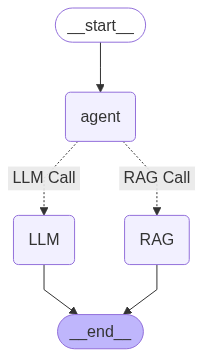

In [44]:
try:
    display(Image(app.get_graph().draw_mermaid_png(max_retries=2, retry_delay=2.0)))
except Exception as e:
    print(e)

In [45]:
inputs = {"messages": ["Tell me about Japan's Industrial Growth"]}
out = app.invoke(inputs)

-> Calling Agent ->
Topic='Japan'
-> Router ->
Japan
-> Calling RAG ->


In [46]:
out

{'messages': ["Tell me about Japan's Industrial Growth",
  'Japan',
  "I'm sorry, but based on the given context, there is no information provided about Japan's Industrial Growth."]}

In [47]:
input= {"messages": ["Tell me about USA first president?"]}

In [48]:
out= app.invoke(input)

-> Calling Agent ->
Topic='Not Related'
-> Router ->
Not Related
-> Calling LLM ->


In [49]:
out

{'messages': ['Tell me about USA first president?',
  'Not Related',
  'The first President of the United States was George Washington. He served two terms as President from 1789 to 1797. Washington was a key figure in the American Revolution and is often referred to as the "Father of His Country" for his leadership during that time. He played a crucial role in the founding of the United States and is widely regarded as one of the greatest Presidents in American history.']}